# Previsão de preços com Tamanho, Localização e Vizinhança

Nesse projeto final, tentaremos usar todos os recursos do nosso conjunto de dados para aprimorar o modelo. Isso significa que precisaremos fazer uma limpeza mais cuidadosa do conjunto de dados e considerar alguns dos detalhes mais sutis dos modelos lineares.

In [1]:
!pip install category_encoders --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.5 MB/s eta 0:00:00


In [2]:
import warnings
from glob import glob

import pandas as pd
import seaborn as sns
from category_encoders import OneHotEncoder
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge  # noqa F401
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted

warnings.simplefilter(action="ignore", category=FutureWarning)

### Preparação dos dados

Importação

In [3]:
def wrangle(filepath):
    # Read CSV file
    df = pd.read_csv(filepath)

    # Subset data: Apartments in "Capital Federal", less than 400,000
    mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 400_000
    df = df[mask_ba & mask_apt & mask_price]

    # Subset data: Remove outliers for "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]

    # Split "lat-lon" column
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns="lat-lon", inplace=True)

    # Get place name
    df["neighborhood"] = df["place_with_parent_names"].str.split("|", expand=True)[3]
    df.drop(columns="place_with_parent_names", inplace=True)

    # Drop columns with high null counts
    df.drop(columns=["floor", "expenses"], inplace=True)

    # Drop low- an high-cardinality categorical variables
    df.drop(columns=["operation", "property_type", "currency", "properati_url"], inplace=True)

    # Drop leaky columns
    df.drop(columns=[
        'price',
        'price_aprox_local_currency',
        'price_per_m2',
        'price_usd_per_m2'
        ],
        inplace=True
    )

    # Drop columns with multicollinearlity
    df.drop(columns=["surface_total_in_m2", "rooms"], inplace=True)

    return df

In [4]:
files = glob("/content/buenos-aires-real-estate-*.csv")
files

['/content/buenos-aires-real-estate-4.csv',
 '/content/buenos-aires-real-estate-2.csv',
 '/content/buenos-aires-real-estate-5.csv',
 '/content/buenos-aires-real-estate-1.csv',
 '/content/buenos-aires-real-estate-3.csv']

In [5]:
frames = [wrangle(file) for file in files]
print("Total de data frames: ", len(frames))
for frame in frames:
    print(frame.shape)

Total de data frames:  5
(1305, 5)
(1315, 5)
(1331, 5)
(1343, 5)
(1288, 5)


In [6]:
df = pd.concat(frames, ignore_index=True)
print(df.shape)
df.head()

(6582, 5)


,price_aprox_usd,surface_covered_in_m2,lat,lon,neighborhood
0,59000.0,40.0,-34.604069,-58.460209,Paternal
1,78900.0,38.0,-34.620026,-58.388467,Congreso
2,240000.0,88.0,-34.599857,-58.489002,Agronomía
3,75000.0,34.0,-34.612338,-58.401328,Balvanera
4,110000.0,46.0,-34.586160,-58.475633,Parque Chas


### Exploração

* A primeira coisa que precisamos considerar ao tentar usar todos os recursos do df são os valores ausentes. Embora seja possível imputar valores ausentes, ainda é necessário que haja dados suficientes em uma coluna para uma boa imputação. Uma regra geral é que, se mais da metade dos dados em uma coluna estiverem ausentes, é melhor descartá-los do que tentar imputar

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6582 entries, 0 to 6581
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   operation                   6582 non-null   object 
 1   property_type               6582 non-null   object 
 2   price                       6582 non-null   float64
 3   currency                    6582 non-null   object 
 4   price_aprox_local_currency  6582 non-null   float64
 5   price_aprox_usd             6582 non-null   float64
 6   surface_total_in_m2         4752 non-null   float64
 7   surface_covered_in_m2       6582 non-null   float64
 8   price_usd_per_m2            4536 non-null   float64
 9   price_per_m2                6582 non-null   float64
 10  floor                       1900 non-null   float64
 11  rooms                       5286 non-null   float64
 12  expenses                    1739 non-null   float64
 13  properati_url               6582 

As colunas "floor" e "expenses" possuem uma alta quantidade de valores nulos, mais de 50%, o que faz sentido a exclusão dessas colunas.

Ajustei a noss função wrangle() realizar a exclusão das colunas mencionadas.

* A próxima coisa que precisamos observar são colunas categóricas com cardinalidade baixa ou alta. Se houver apenas uma categoria em uma coluna, ela não fornecerá nenhuma informação exclusiva para o nosso modelo. No outro extremo, colunas em que quase todas as linhas têm sua própria categoria não ajudarão nosso modelo a identificar tendências úteis nos dados.

Vamos dar uma olhada na cardinalidade dos nossos recursos.

In [ ]:
df.select_dtypes("object").head()

,operation,property_type,currency,properati_url,neighborhood
0,sell,apartment,USD,http://paternal.properati.com.ar/12t3j_venta_d...,Paternal
1,sell,apartment,USD,http://congreso.properati.com.ar/12j7y_venta_d...,Congreso
2,sell,apartment,USD,http://agronomia.properati.com.ar/10vec_venta_...,Agronomía
3,sell,apartment,USD,http://balvanera.properati.com.ar/10vnl_venta_...,Balvanera
4,sell,apartment,USD,http://parque-chas.properati.com.ar/yc23_venta...,Parque Chas


In [ ]:
df.select_dtypes("object").nunique()

,0
operation,1
property_type,1
currency,2
properati_url,6582
neighborhood,57


Podemos observar que as colunas "operation", "property_type" e "currency" possuem baixa cardinalidade, ou seja, apresentam poucos valores distintos e, consequentemente, contribuem com pouca informação útil para os nossos modelos.

Por outro lado, a coluna "properati_url" possui alta cardinalidade, apresentando praticamente um valor único para cada observação do DataFrame. Isso também não agrega valor relevante à modelagem, pois não há nenhuma tendência ou padrão que possa ser identificado. Além disso, caso utilizássemos o OneHotEncoder, seriam geradas 6.582 novas colunas, o que tornaria a iteração do modelo extremamente ineficiente.

Ajustei a nossa função wrangle() para realizar a exclusão das colunas mencionadas acima.

* Também é importante que descartemos quaisquer colunas que possam constituir vazamento, ou seja, recursos que foram criados usando nosso destino ou que forneceriam ao nosso modelo informações às quais ele não teria acesso quando fosse implantado.

In [ ]:
sorted(df.columns)

['lat',
 'lon',
 'neighborhood',
 'price',
 'price_aprox_local_currency',
 'price_aprox_usd',
 'price_per_m2',
 'price_usd_per_m2',
 'rooms',
 'surface_covered_in_m2',
 'surface_total_in_m2']

A nossa variável alvo é "price_aprox_usd", porém o DataFrame contém outras variáveis relacionadas a preço que podem fornecer pistas ao modelo, levando-o a “roubar” durante as previsões. Isso acontece porque queremos que o modelo aprenda a prever o preço sem ter acesso direto a informações que já antecipam o resultado.

É como se estivéssemos tentando prever o placar de um jogo de futebol, mas o modelo soubesse previamente quantos pontos o time conquistou ao final da partida. Com essa informação, fica fácil saber se o time venceu ou perdeu, o que invalida o processo de previsão real.

Ajuestei nossa função wrangle() para excluir as colunas relacionadas a preço.

* Por fim, a última questão que precisamos observar é a multicolinearidade, ou seja, características em nossa matriz de características altamente correlacionadas entre si. Uma boa maneira de detectar isso é usar um mapa de calor. Vamos criar um!

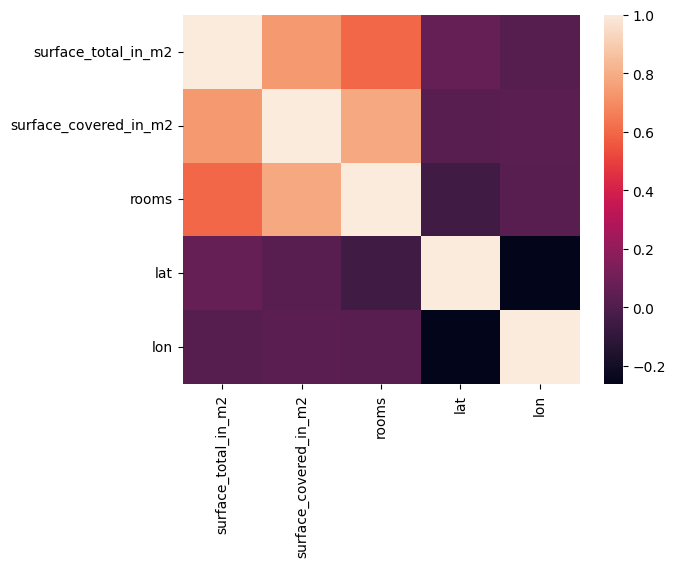

In [ ]:
corr = df.select_dtypes("number").drop(columns="price_aprox_usd").corr()
sns.heatmap(corr);

Ao observar a matriz de correlação entre as variáveis numéricas do conjunto de dados, é possível identificar sinais de multicolinearidade, principalmente entre algumas variáveis relacionadas à área dos imóveis.

As variáveis surface_total_in_m2 e surface_covered_in_m2 apresentam uma correlação muito alta entre si, o que indica que ambas carregam praticamente a mesma informação. Isso pode ser problemático em modelos lineares, pois dificulta a interpretação dos coeficientes e pode levar à instabilidade nos resultados.

Além disso, a variável rooms também possui uma correlação moderada com as variáveis de área (surface_total_in_m2 e surface_covered_in_m2), o que pode intensificar o efeito da multicolinearidade, dependendo do modelo adotado.

Já as variáveis lat e lon (latitude e longitude) não apresentam correlação relevante com as demais e, portanto, não representam risco de multicolinearidade.

É recomendável remover uma das variáveis de área, como surface_total_in_m2 ou surface_covered_in_m2, a fim de reduzir a redundância de informação e evitar problemas de multicolinearidade nos modelos preditivos.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6582 entries, 0 to 6581
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        6582 non-null   float64
 1   surface_total_in_m2    4752 non-null   float64
 2   surface_covered_in_m2  6582 non-null   float64
 3   rooms                  5286 non-null   float64
 4   lat                    6316 non-null   float64
 5   lon                    6316 non-null   float64
 6   neighborhood           6582 non-null   object 
dtypes: float64(6), object(1)
memory usage: 360.1+ KB


Durante a análise exploratória das variáveis, identificamos uma alta correlação entre surface_total_in_m2, surface_covered_in_m2 e rooms. Isso indica redundância de informação entre essas variáveis, o que pode prejudicar a performance e a interpretabilidade do modelo, especialmente em algoritmos sensíveis à multicolinearidade.

A decisão de remover surface_total_in_m2 e rooms foi baseada nos seguintes critérios:

Disponibilidade de dados:

* surface_total_in_m2: apenas 4.752 valores não nulos (~72% do total).

* rooms: 5.286 valores não nulos (~80% do total).

* surface_covered_in_m2: 6.582 valores não nulos (100% do dataset).

Relevância prática:

* surface_covered_in_m2 representa a área construída, que tende a ser mais diretamente relacionada ao valor do imóvel.

* O número de cômodos (rooms) tem uma correlação significativa com a área construída, mas oferece uma informação menos precisa e mais subjetiva.

Redução de multicolinearidade:
Manter todas essas variáveis aumentaria a multicolinearidade no modelo. Como surface_covered_in_m2 já capta boa parte da variação explicada pelas demais, optamos por mantê-la e excluir as outras.

Optamos por manter apenas a variável surface_covered_in_m2 e remover surface_total_in_m2 e rooms do conjunto de dados. Essa decisão ajuda a manter a consistência, evitar perda de registros e reduzir a redundância entre as variáveis preditoras, contribuindo para um modelo mais enxuto e eficiente.

Ajustei a função wrangle() para excluir as colunas mencionadas.

### Split Data

Criando matriz de características X_train e o vetor de destino y_train.

In [7]:
target = "price_aprox_usd"
y_train = df[target]
X_train = df.drop(columns=target)

### Construindo modelo

Baseline

In [8]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
print("Mean apt price:", round(y_mean, 2))

print("Baseline MAE:", mean_absolute_error(y_train, y_pred_baseline))

Mean apt price: 132383.84
Baseline MAE: 44860.10834274133


### Iterate

In [9]:
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    Ridge()
)
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['neighborhood'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

### Evaluate

Calculando o erro absoluto médio de treinamento para as previsões em comparação com os alvos reais em y_train.

In [10]:
y_pred_training = model.predict(X_train)
print("Training MAE:", mean_absolute_error(y_train, y_pred_training))

Training MAE: 24207.107190330287


### Comunicando resultados

Neste projeto, utilizamos equações e visualizações para a comunicação sobre nosso modelo. Em muitos projetos de ciência de dados, no entanto, comunicação significa fornecer às partes interessadas ferramentas que elas podem usar para implementar um modelo — em outras palavras, usá-lo em ação. Então, vamos analisar duas maneiras de implementar este modelo.

Uma coisa que pode ser solicitada é encapsular seu modelo em uma função para que um programador possa fornecer entradas e, em seguida, receber uma previsão como saída.

In [11]:
def make_prediction(area, lat, lon, neighborhood):
    data = {
        "surface_covered_in_m2": area,
        "lat": lat,
        "lon": lon,
        "neighborhood": neighborhood
    }

    df = pd.DataFrame(data, index=[0])
    prediction = model.predict(df).round(2)[0]
    return f"Predicted apartment price: ${prediction}"

In [12]:
make_prediction(110, -34.60, -58.46, "Villa Crespo")

'Predicted apartment price: $250775.11'

Outro tipo de implantação é a criação de um painel interativo, onde o usuário pode fornecer valores e receber uma previsão. Vamos criar um usando os widgets do Jupyter.

In [ ]:
interact(
    make_prediction,
    area=IntSlider(
        min=X_train["surface_covered_in_m2"].min(),
        max=X_train["surface_covered_in_m2"].max(),
        value=X_train["surface_covered_in_m2"].mean(),
    ),
    lat=FloatSlider(
        min=X_train["lat"].min(),
        max=X_train["lat"].max(),
        step=0.01,
        value=X_train["lat"].mean(),
    ),
    lon=FloatSlider(
        min=X_train["lon"].min(),
        max=X_train["lon"].max(),
        step=0.01,
        value=X_train["lon"].mean(),
    ),
    neighborhood=Dropdown(options=sorted(X_train["neighborhood"].unique())),
);

Você deve ter notado que existem muitas maneiras de aprimorar este painel. Por exemplo, um usuário pode selecionar um bairro e fornecer coordenadas de latitude e longitude que não estejam naquele bairro. Também seria útil incluir uma visualização, como um mapa. De qualquer forma, este é um ótimo primeiro passo para a criação de painéis dinâmicos que transformam seu modelo de uma abstração complexa em uma ferramenta concreta acessível a qualquer pessoa. Uma das partes mais importantes dos projetos de ciência de dados é criar produtos que as pessoas possam usar para facilitar seu trabalho ou sua vida.

rodinha